# Equation of State using Generalized van der Waals Theory

This notebook illustrates the generalized van der Waals theory (gvdW) for the equation of state for interacting particles. Based on the lecture notes, _Properties of Molecular Fluids in Equilibrium_ by Sture Nordholm.

In [1]:
from __future__ import division, unicode_literals, print_function
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import inspect
from scipy.integrate import quad
from ipywidgets import interact
from math import sqrt, pi
plt.rcParams.update({'font.size': 16, 'figure.figsize': [8.0, 6.0]})

### Pair potentials

The particles are here assumed to interact via a Lennard-Jones and a screened Coulomb potential,

$$
\beta w(r) = \frac{\lambda_B z^2}{r} e^{-r/\lambda_D}
+ 4\beta \varepsilon_{LJ} \left ( \left ( \frac{\sigma}{r}\right )^{12} - \left ( \frac{\sigma}{r}\right )^{6}\right )
$$

where $\lambda_B$ and $\lambda_D$ are the Bjerrum and Debye lengths, respectively.
Any potential may in principle be given and must return the energy in units of $k_BT$.

## Define your own potentials below

* The name should start with `potential_`
* The first parameter should be `r`
* The docstring can be added for a nice displayname of the function (The raw python string like `r"$ \mu $"` is convenient when writing latex, because in normal strings the backslash acts as an escape character) 

In [2]:
# Debye-Huckel
def potential_wDH(r, z, D):
    r"""$\frac{\lambda_B z^2}{r} e^{-r/\lambda_D}$"""
    lB = 7.0 # Bjerrum length, angstroms
    return lB * z**2 * np.exp(-r/D) / r

# Lennard-Jones
def potential_wLJ(r, eps, sigma):
    r"""$4\beta \varepsilon_{LJ} \left ( \left ( \frac{\sigma}{r}\right )^{12} - \left ( \frac{\sigma}{r}\right )^{6}\right )$"""
    return 4 * eps * ( (sigma/r)**12 - (sigma/r)**6 )

# Total potential
def potential_w(r, z, D, eps, sigma):
    r"""$\frac{\lambda_B z^2}{r} e^{-r/\lambda_D} + 4\beta \varepsilon_{LJ} \left ( \left ( \frac{\sigma}{r}\right )^{12} - \left ( \frac{\sigma}{r}\right )^{6}\right )$"""
    return potential_wDH(r, z, D) + potential_wLJ(r, eps, sigma)

### Interaction parameter

Here we integrate the above pair potential to get the average interaction energy per particle, assuming that the pair correlation function, $g(r)$, can be described by a simple step function, zero when $r<\sigma$, unity otherwise:
$$ 
\hat{a} = -\frac{1}{2} \int_{\sigma}^{\infty} 4\pi w(r) r^2 dr
$$

In this Notebook we simply do the integration numerically so that we can use arbitrary pair potentials.
From this we calculate the pressure, $p$, versus density, $n$, using,

$$
\beta p_{gvdW} = \frac{1}{v-v_0} - \frac{\hat{a}}{v^2}
$$

where $v=1/n$ and $v_0=2\pi\sigma^3/3$ is the particle volume.
For reference we'll also plot EOS for an ideal system (van 't Hoff), $\beta p_{ideal}=n$,
where $\beta = 1/k_BT$.

In [3]:
def ahat(potential, **parameters):
    sigma = parameters['sigma']
    # extract the relevant parameters for the potential
    parameters = {k:v for k,v in parameters.items() if k in inspect.signature(potential).parameters}
    
    def integrand(r):
        return potential(r, **parameters) * r**2
    integral, error = quad(integrand, sigma, np.infty, limit=50)
    return -2 * pi * integral


def ahatexact(z, D, eps, sigma):
    return -2 * pi * (-8/9 * eps * sigma**3 + 7 * np.exp(-sigma/D) * z**2 * (D + sigma))

def Pideal(n):
    return n

def Pgvdw(n, z, D, eps, sigma, potential=potential_w):
    v0 = 2*pi*sigma**3 / 3
    v  = 1 / n
    a = ahat(potential, z=z, D=D, eps=eps, sigma=sigma)
    return 1/(v-v0) - a/v**2

### Interactive EOS plot

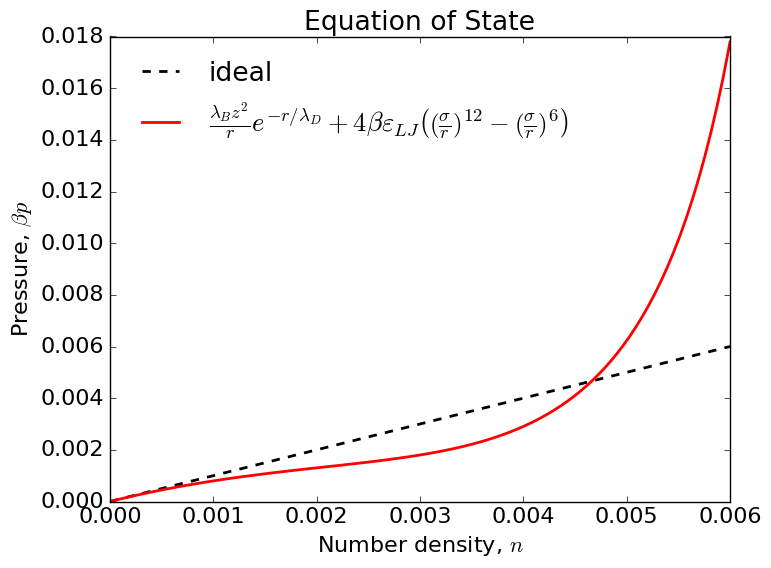

In [4]:
def plot_EOS( eps=1.0, sigma=4.0, z=0.0, Cs=0.3, potential=potential_w):
    D = 3.04/sqrt(Cs)
#     plt.title(potential.__doc__)
    plt.plot(n, Pideal(n),  'k--', label='ideal', lw=2)
    plt.plot(n, Pgvdw(n, z, D, eps, sigma, potential=potential),  'r-', label=potential.__doc__ or potential.__name__, lw=2)
    plt.title('Equation of State')
    plt.xlabel(r'Number density, $n$')
    plt.ylabel(r'Pressure, $\beta p$')
    plt.legend(loc=0, frameon=False)

n = np.linspace(1e-7, 6e-3, 100)

_potentials = {fname: func for fname, func in globals().items() if fname.startswith("potential_")}

i = interact(plot_EOS,
             eps=(0.0, 10.0, 0.1), 
             sigma=(0, 5, 0.1),
             z=(0.0, 10, 1.0), 
             Cs=(1e-3, 1.0, 0.1), 
             potential = _potentials )

plt.title('Equation of State')
plt.xlabel(r'Number density, $n$')
plt.ylabel(r'Pressure, $\beta p$')
plt.legend(loc=0, frameon=False)
 
i.widget.children[0].description=r'$\beta\varepsilon_{LJ}$'
i.widget.children[1].description=r'$\sigma_{LJ}$'
i.widget.children[2].description=r'$z$'
i.widget.children[3].description=r'$c_s$ (M)'